<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from collections import Counter

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
from sklearn.exceptions import ConvergenceWarning

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


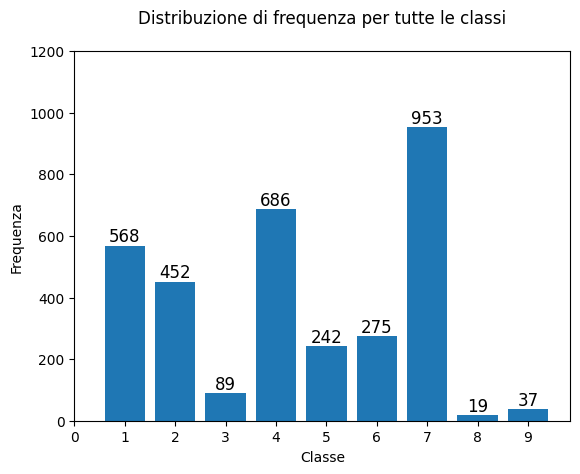

In [5]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()



<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [6]:
from nltk.stem import PorterStemmer

# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

# Inizializzazione dello stemmer
stemmer = PorterStemmer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e stemming
    tokens = word_tokenize(text)
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)


def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))

In [7]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [03:28<00:00, 15.91it/s]


In [8]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin depend kinas cdk regul varieti fundamen...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evid demonstr acquir uniparent disomi a...
4,4,CBL,L399V,4,oncogen mutat monomer casita lineag lymphoma c...


In [9]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [10]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


In [11]:
print(df.head())

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  
0  cyclin depend kinas cdk regul varieti fundamen...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evid demonstr acquir uniparent disomi a...  
4  oncogen mutat monomer casita lineag lymphoma c...  


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3316 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3316 non-null   int64 
 1   Gene       3316 non-null   object
 2   Variation  3316 non-null   object
 3   Class      3316 non-null   int64 
 4   text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.4+ KB
None


In [13]:
print(df.describe(include='all'))

                 ID   Gene             Variation        Class  \
count   3316.000000   3316                  3316  3316.000000   
unique          NaN    262                  2993          NaN   
top             NaN  BRCA1  Truncating Mutations          NaN   
freq            NaN    264                    92          NaN   
mean    1660.034077    NaN                   NaN     4.366104   
std      959.287860    NaN                   NaN     2.309241   
min        0.000000    NaN                   NaN     1.000000   
25%      828.750000    NaN                   NaN     2.000000   
50%     1661.500000    NaN                   NaN     4.000000   
75%     2490.250000    NaN                   NaN     7.000000   
max     3320.000000    NaN                   NaN     9.000000   

                                                     text  
count                                                3316  
unique                                               1920  
top     pten phosphatas tensin homolog 

In [14]:
print("Numero di geni unici:", df['Gene'].nunique())
print("Numero di varianti uniche:", df['Variation'].nunique())

Numero di geni unici: 262
Numero di varianti uniche: 2993


In [15]:
gene_counts = df['Gene'].value_counts()
variation_counts = df['Variation'].value_counts()

print("Top 10 geni più frequenti:")
print(gene_counts.head(10))

print("Top 10 varianti più frequenti:")
print(variation_counts.head(10))

Top 10 geni più frequenti:
Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       92
ALK        69
ERBB2      69
PDGFRA     60
Name: count, dtype: int64
Top 10 varianti più frequenti:
Variation
Truncating Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: count, dtype: int64


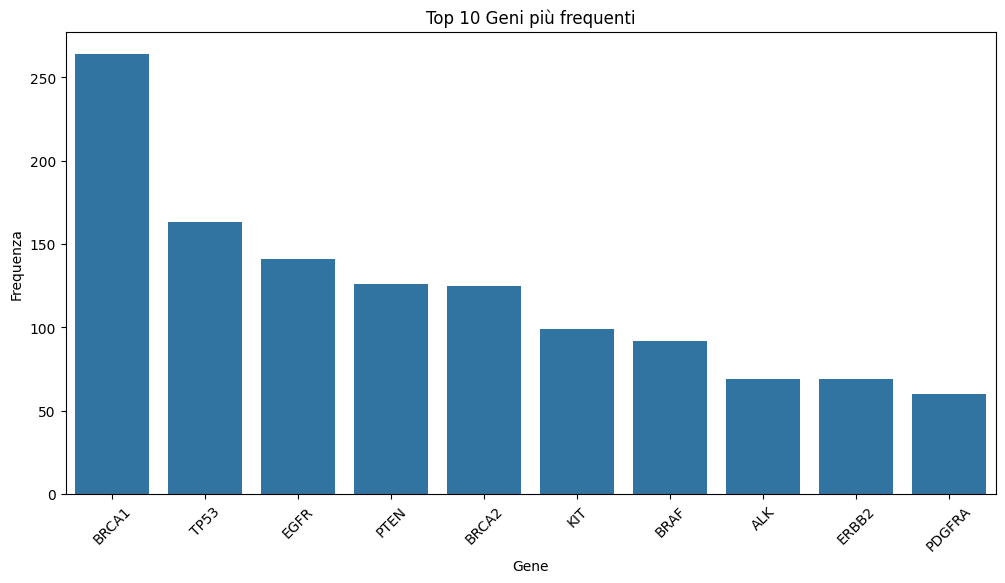

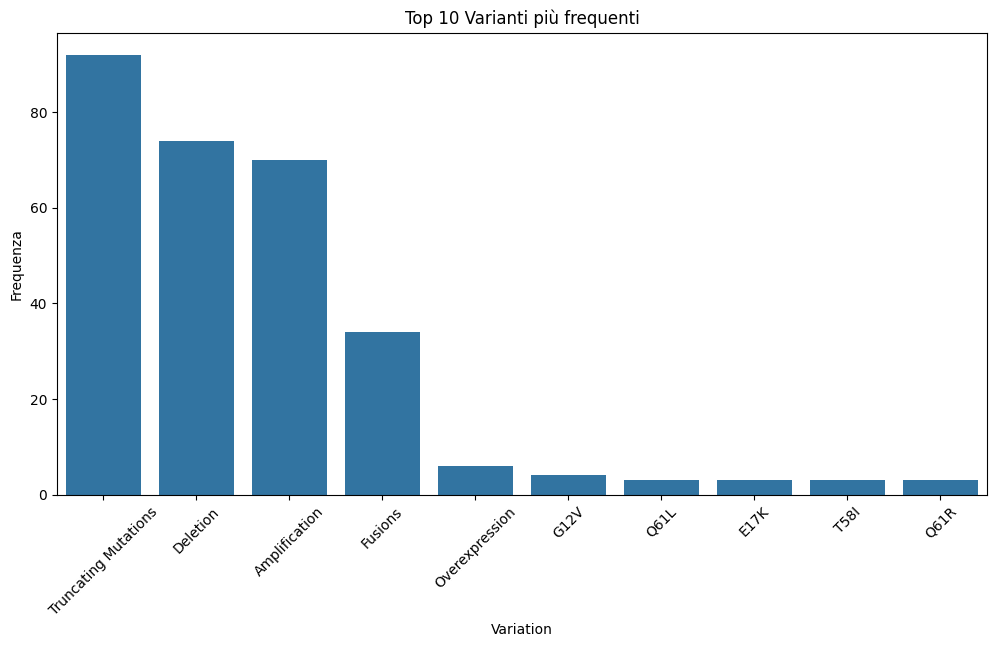

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x=gene_counts.head(10).index, y=gene_counts.head(10).values)
plt.title('Top 10 Geni più frequenti')
plt.xlabel('Gene')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=variation_counts.head(10).index, y=variation_counts.head(10).values)
plt.title('Top 10 Varianti più frequenti')
plt.xlabel('Variation')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()

In [17]:
class_counts = df['Class'].value_counts()

print("Distribuzione delle classi:")
print(class_counts)

Distribuzione delle classi:
Class
7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: count, dtype: int64


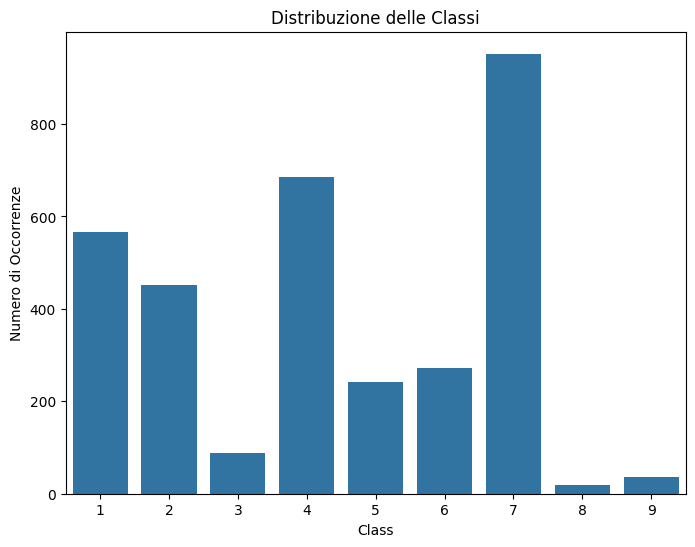

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribuzione delle Classi')
plt.xlabel('Class')
plt.ylabel('Numero di Occorrenze')
plt.show()

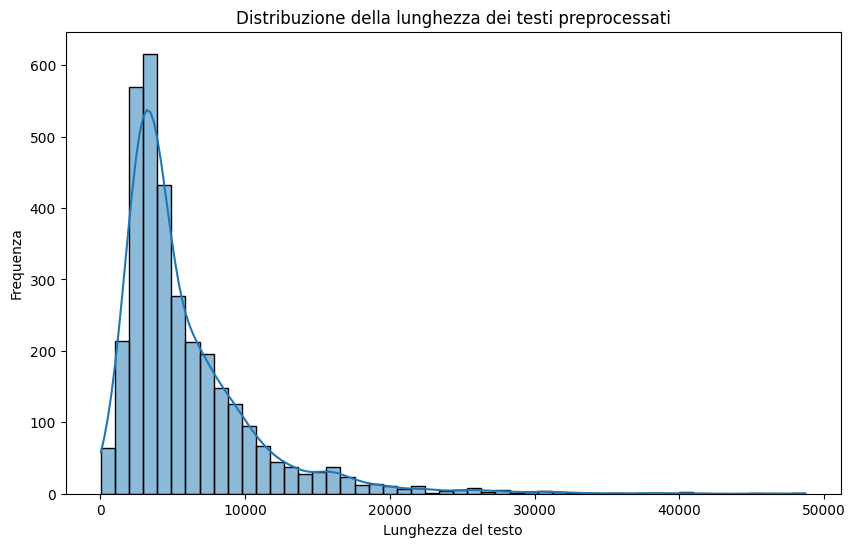

In [19]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribuzione della lunghezza dei testi preprocessati')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Frequenza')
plt.show()

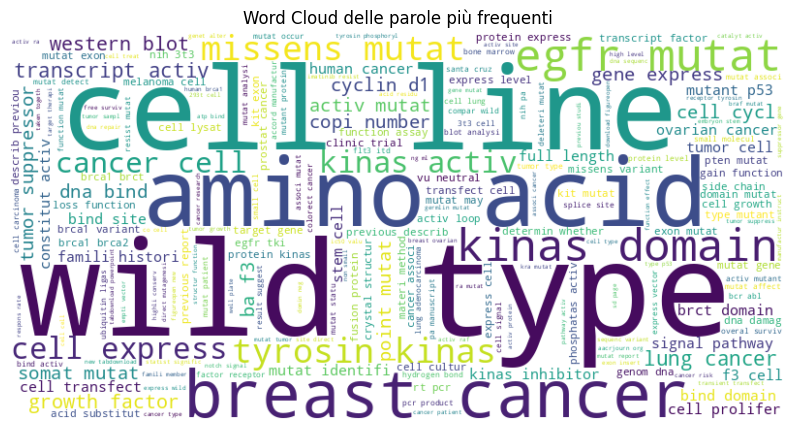

In [20]:
all_text = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud delle parole più frequenti')
plt.show()